In [6]:
# my horrible spaghetti that imports and prepares the data, and then splits it into training, validation and test sets 

import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans
import pandas as pd


cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path for data directory!", Flush=True)

clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
#a list of light curve 2D arrays

lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves

lcs_abu_std=sc.scaling(lcs_abu, method="standard")
# data is standardised, x_i_stand = (x_i - x_mean)/x_std
# mean+n*sigma is going to be the assumed maximum count rate that will be used to normalise the data

x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu_std, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

In [7]:
importlib.reload(sc)
##train the model
model_class="rho"
#hyperparameters and settings
n_clusters=10
length=10
time_stamps=False
offset=True
#loop throught the light curves of a given class and segments them
training_ys=np.where(np.array(y_train)=='{}'.format(model_class))[0]
all_train_segments=[]
for ts_i in training_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, length, 2, time_stamps=time_stamps)
    #c_train_segments=sc.center_window(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(train_segments)
all_train_segments=np.vstack(all_train_segments)
#cluster the segments
cluster=KMeans(n_clusters=n_clusters, random_state=0)
cluster.fit(all_train_segments)
clusters=cluster.fit_predict(all_train_segments)

In [8]:
clusters

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

[0.71528698 0.19601169 0.04133041 0.01594682 0.00952891 0.00625
 0.00505753 0.00416366 0.00345855 0.00296545]
1.0


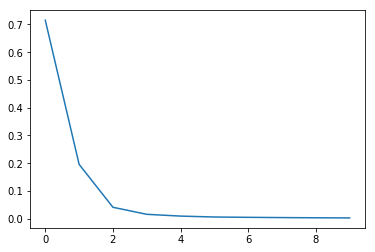

In [9]:
from sklearn.decomposition import PCA
pca= PCA()
pca.fit(all_train_segments)
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[:10]))
trans_data = pca.transform(all_train_segments) 

In [10]:
trans_data = pca.transform(all_train_segments) 

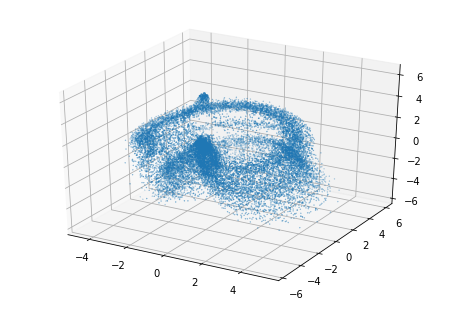

In [76]:
%matplotlib inline
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(trans_data[:,0],trans_data[:,1],trans_data[:,2], s=0.1)
plt.show()

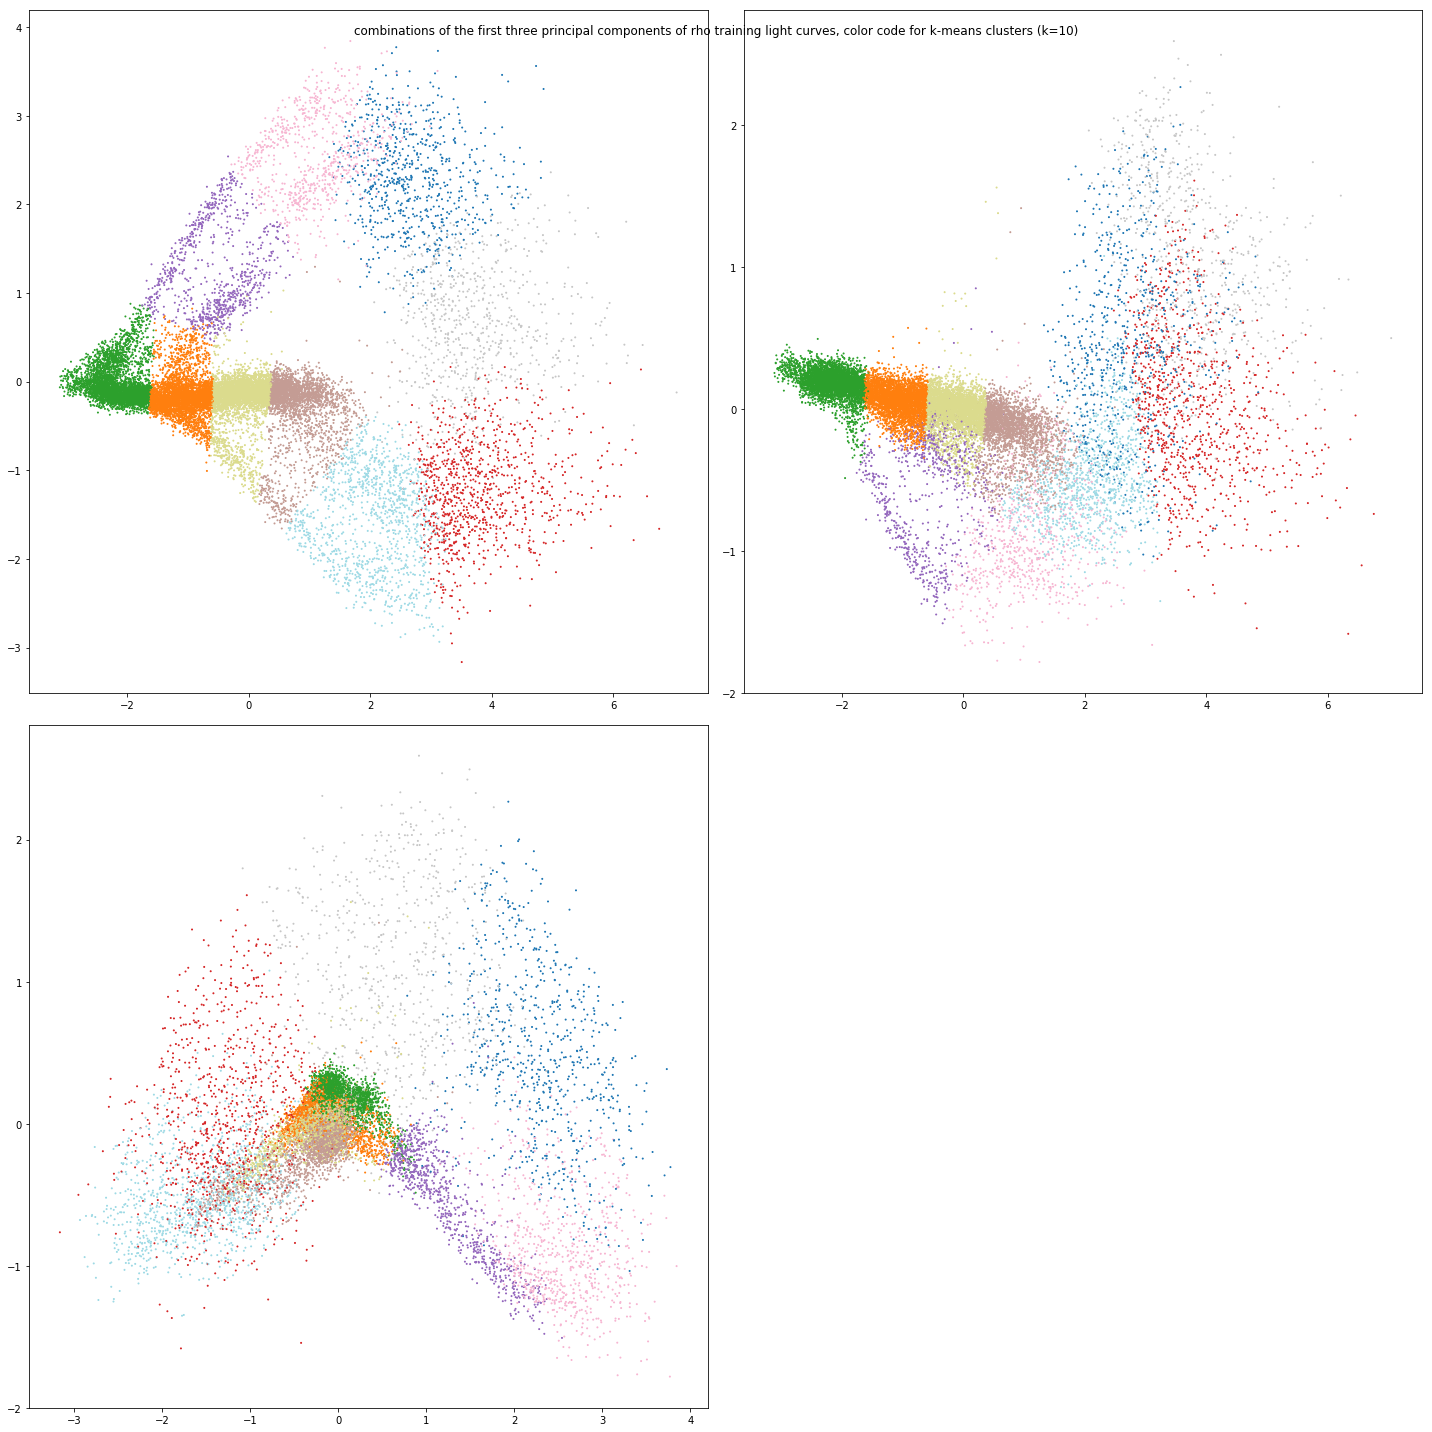

In [11]:
%matplotlib inline
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.scatter(trans_data[:,0],trans_data[:,1],s=1, c=clusters, cmap="tab20")
plt.subplot(222)
plt.scatter(trans_data[:,0],trans_data[:,2],s=1, c=clusters, cmap="tab20")
plt.subplot(223)
plt.scatter(trans_data[:,1],trans_data[:,2],s=1, c=clusters, cmap="tab20")
plt.tight_layout()
plt.suptitle("combinations of the first three principal components of rho training light curves, color code for k-means clusters (k=10)")
#plt.savefig("PCA_k10_sin3.png", dpi=300)
plt.show()

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(all_train_segments)

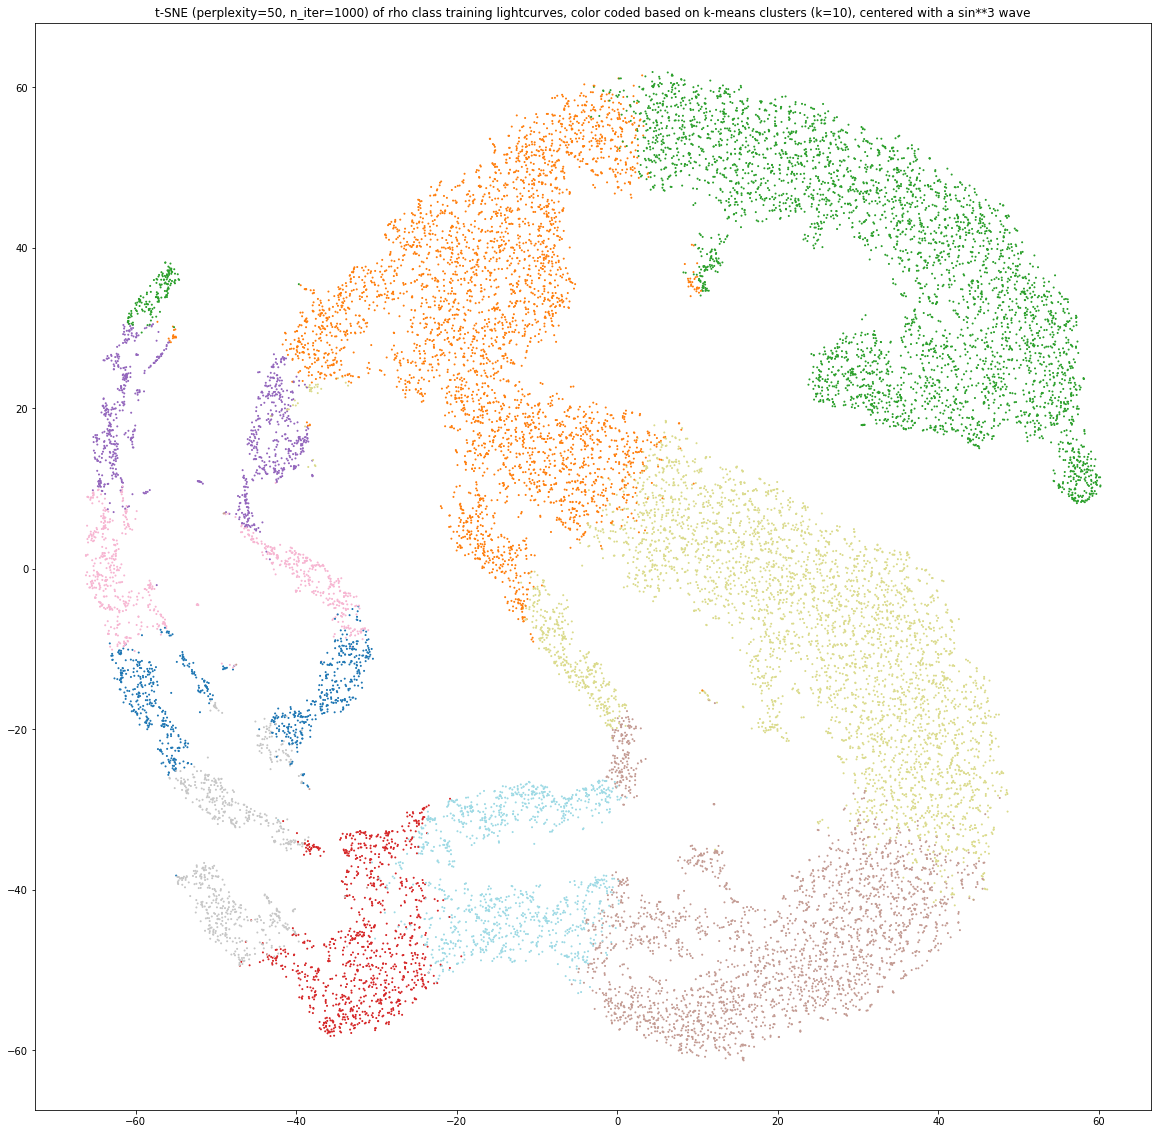

In [13]:
#50
plt.figure(figsize=(20,20))
plt.title("t-SNE (perplexity=50, n_iter=1000) of rho class training lightcurves, color coded based on k-means clusters (k=10), centered with a sin**3 wave")
plt.scatter(tsne_results[:,0],tsne_results[:,1], s=1, c=clusters, cmap="tab20")




from scipy.spatial import ConvexHull

for n_cluster in range(10):
    n_inds = np.where(clusters == n_cluster)[0]
    points = tsne_results[n_inds]
    hull = ConvexHull(points)
   #for simplex in hull.simplices:
      # plt.plot(points[simplex, 0], points[simplex, 1], "k-")
#plt.savefig("tsne_k10_1000iter_sin3.png", dpi=300)
plt.show()

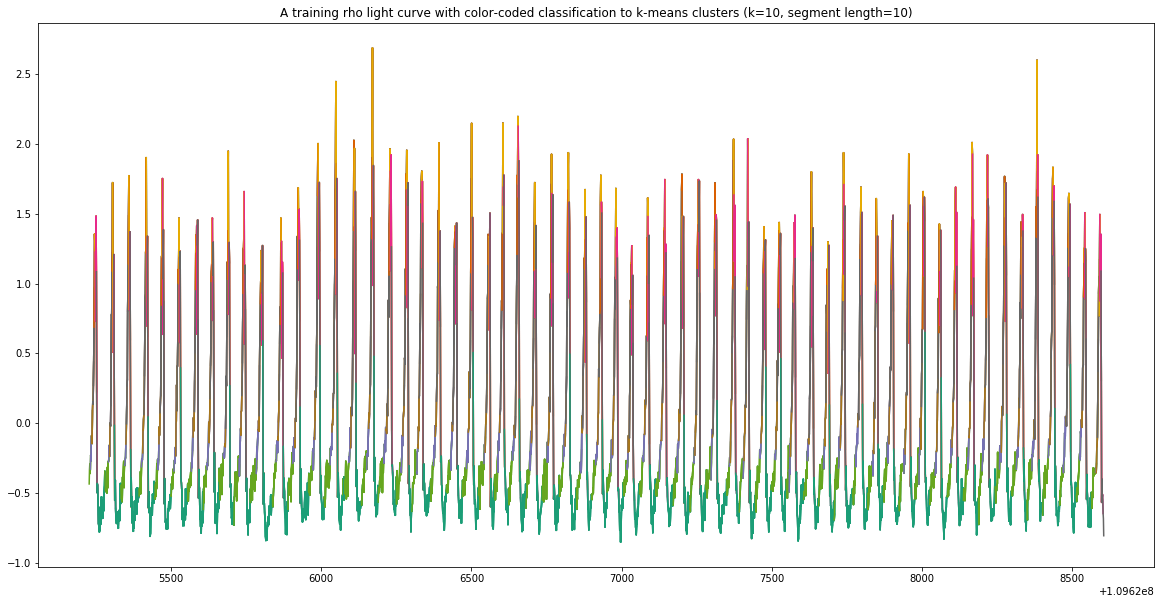

In [156]:
plt.figure(figsize=(20,10))
lc=x_train[training_ys[5]]
lc_seg=sc.segmentation(lc, 10, 2, time_stamps=True)
clusters=cluster.fit_predict(np.array(lc_seg)[:,1])
#lc_center=sc.center_window(lc_seg, lc, offset=False, time_stamps=True)
for n, segment in enumerate(lc_seg):
    plt.plot(segment[0],segment[1], color=plt.cm.Dark2(clusters[n]))#, alpha=1)
plt.title("A training rho light curve with color-coded classification to k-means clusters (k=10, segment length=10)")
#plt.savefig("colored_rho_lightcurve.png", dpi=300)
plt.show()

In [143]:
print(clusters[:25])

[4 4 2 2 6 6 8 7 1 5 3 3 9 0 0 0 0 0 0 0 0 0 0 0 0]


In [157]:
print(clusters[30:55])

[4 4 2 2 6 8 7 7 1 5 3 9 0 0 0 0 0 0 0 0 0 0 0 4 4]


In [1]:
import pywt
pywt.swt(all_train_segments)

In [2]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',